In [1]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl
from uncertainties import unumpy as up

In [2]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [3]:
def pos(x,pos):
    for i in range(len(pos)):
        if pos[i]>=x:
            return i
            break

In [4]:
def gaus1fit(von,bis,path,x,y,err,yscale,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 

            
    data=[x,y,err]
    vonarr = pos(von,x)
    bisarr = pos(bis,x)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=y[vonarr:bisarr],x=x[vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(y[vonarr:bisarr],x=x[vonarr:bisarr],weights=1/err[vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(x[vonarr:bisarr],yscale*y[vonarr:bisarr],yerr=yscale*err[vonarr:bisarr],fmt='.',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.errorbar(x[0:vonarr],yscale*y[0:vonarr],yerr=yscale*err[0:vonarr],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.errorbar(x[bisarr:-1],yscale*y[bisarr:-1],yerr=yscale*err[bisarr:-1],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)

    plt.plot(np.arange(26,29,0.01),yscale*out_gaus.eval(x=np.arange(26,29,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    #print(out_gaus.fit_report())


    return np.array([np.arange(26,29,0.01),out_gaus.eval(x=np.arange(26,29,0.01))]), out_gaus

def gaus2fit(von,bis,path,x,y,err,yscale,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 


    data=[x,y,err]
    vonarr = pos(von,x)
    bisarr = pos(bis,x)



    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(y,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=y[vonarr:bisarr],x=x[vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1,min=0)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2,min=0)


    #Fitten
    out_gaus = model_gaus.fit(y[vonarr:bisarr],x=x[vonarr:bisarr],weights=1/err[vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(x[vonarr:bisarr],yscale*y[vonarr:bisarr],yerr=yscale*err[vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.errorbar(x[0:vonarr],yscale*y[0:vonarr],yerr=yscale*err[0:vonarr],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.errorbar(x[bisarr:-1],yscale*y[bisarr:-1],yerr=yscale*err[bisarr:-1],fmt='.',ecolor='lightgray',color='b', elinewidth=3, capsize=0,zorder=5)
    plt.plot(np.arange(26,29,0.01),yscale*out_gaus.eval(x=np.arange(26,29,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    
    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(26,29,0.01), out_gaus.eval(x=np.arange(26,29,0.01))]),out_gaus

In [5]:
fig = plt.figure(figsize=(20,10),dpi=80,linewidth=50)
x = [[],[],[]]
data = []
err = []
for i in range(len(os.listdir('Data'))):
    path = 'Data/'+os.listdir('Data')[i]
    print(path)
    with open(path) as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        if len(dataex[3])==151:
            x[0] = dataex[3]
        elif len(dataex[3])==101:
            x[1] = dataex[3]
        elif len(dataex[3])==201:
            x[2] = dataex[3] 
        else:
            print('Error')
        
        data.append(dataex[4])
        err.append(dataex[4]*0.05)


Data/Deltam -0%.csv
Data/Deltam -10%.csv
Data/Deltam -20%.csv
Data/Deltam -30%.csv
Data/Deltam -40%.csv
Data/Deltam -50%.csv
Data/Deltam -60%.csv
Data/Deltam -70%.csv
Data/Deltam -80%.csv
Data/Deltam -90%.csv
Data/Deltam -100%.csv
Data/Deltam -100%V2.csv
Data/Deltam 10%.csv
Data/Deltam 20%.csv
Data/Deltam 30%.csv
Data/Deltam 40%.csv
Data/Deltam 50%.csv
Data/Deltam 60%.csv
Data/Deltam 70%.csv
Data/Deltam 80%.csv
Data/Deltam 90%.csv
Data/Deltam 100%.csv


<Figure size 1600x800 with 0 Axes>

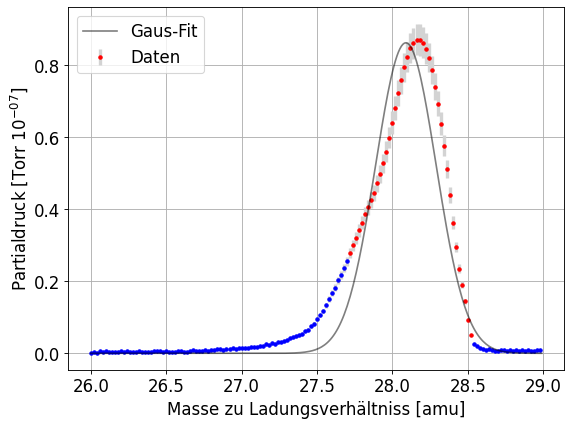

In [6]:
fit0 = gaus1fit(27.72,28.53,'0%',x[0],data[0],err[0],1e7)

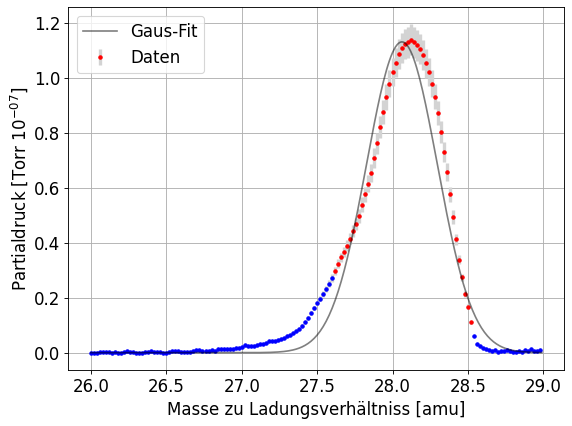

In [7]:
fit_10 = gaus1fit(27.62,28.53,'-10%',x[0],data[1],err[1],1e7)

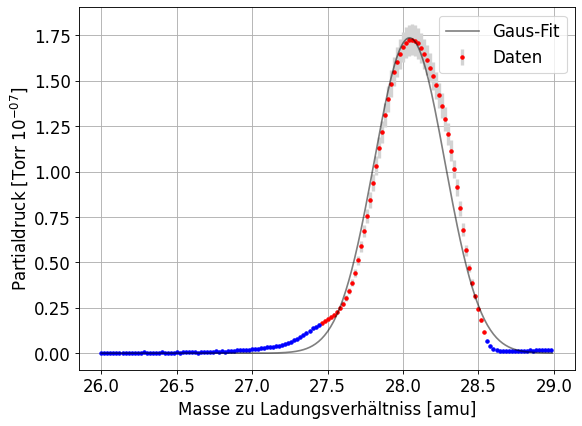

In [8]:
fit_20 = gaus1fit(27.45,28.55,'-20%',x[0],data[2],err[2],1e7)

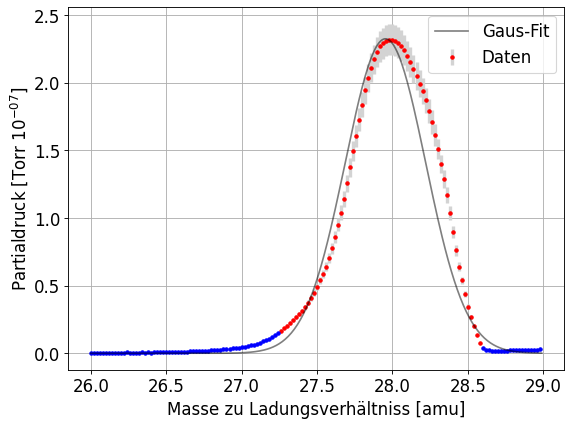

In [9]:
fit_30 = gaus1fit(27.25,28.6,'-30%',x[0],data[3],err[3],1e7)

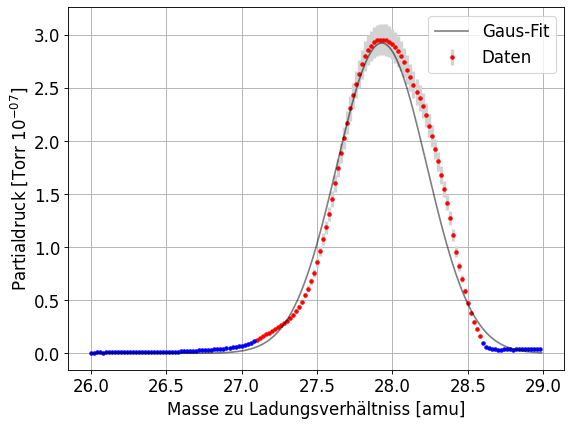

In [10]:
fit_40 = gaus1fit(27.1,28.6,'-40%',x[0],data[4],err[4],1e7)

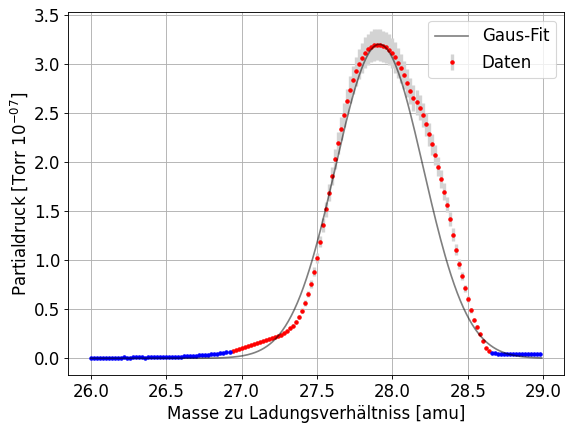

In [11]:
fit_50 = gaus1fit(26.94,28.65,'-50%',x[0],data[5],err[5],1e7)

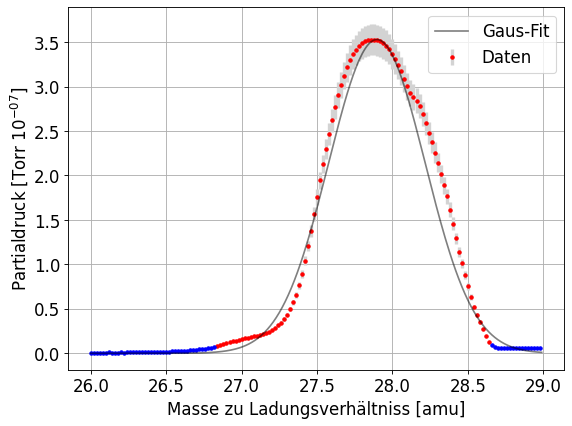

In [12]:
fit_60 = gaus1fit(26.83,28.65,'-60%',x[0],data[6],err[6],1e7)

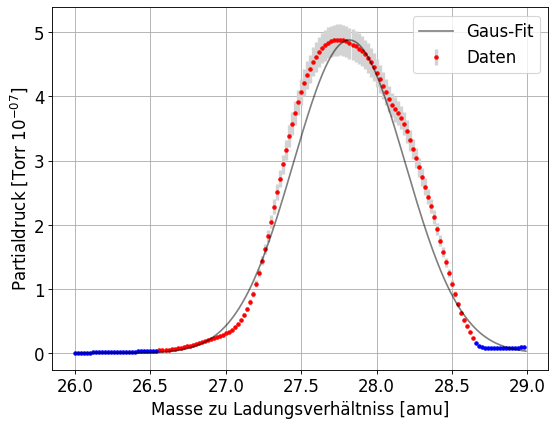

In [13]:
fit_70 = gaus1fit(26.55,28.65,'-70%',x[0],data[7],err[7],1e7)

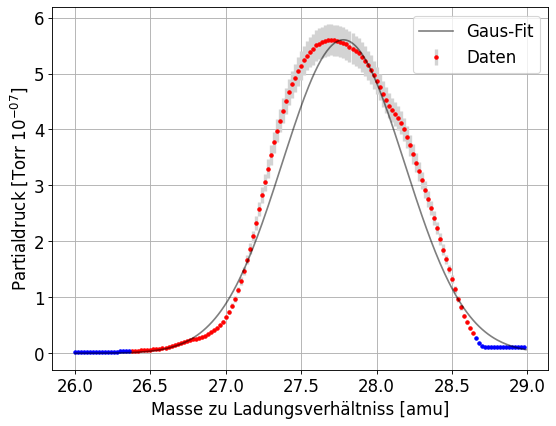

In [14]:
fit_80 = gaus1fit(26.37,28.65,'-80%',x[0],data[8],err[8],1e7)

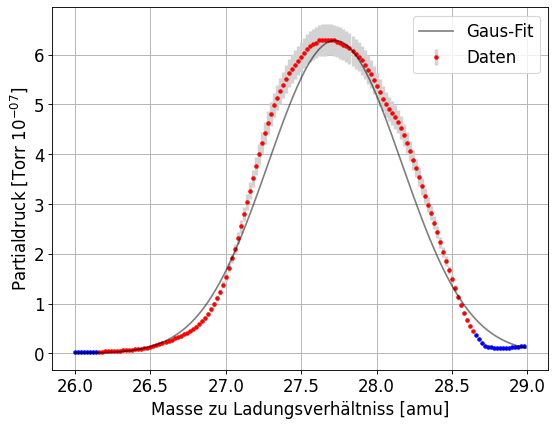

In [15]:
fit_90 = gaus1fit(26.15,28.65,'-90%',x[0],data[9],err[9],1e7)

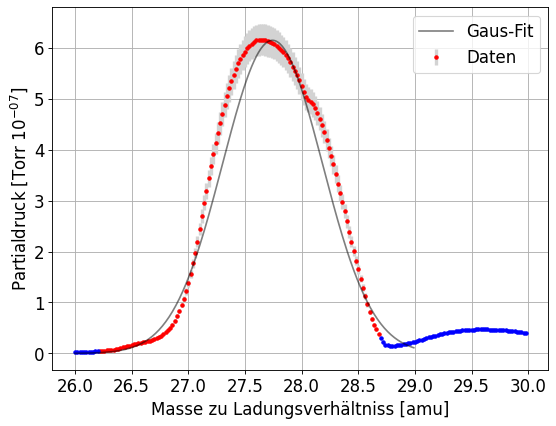

In [16]:
fit_100 = gaus1fit(26.22,28.7,'-100%',x[2],data[10],err[10],1e7)

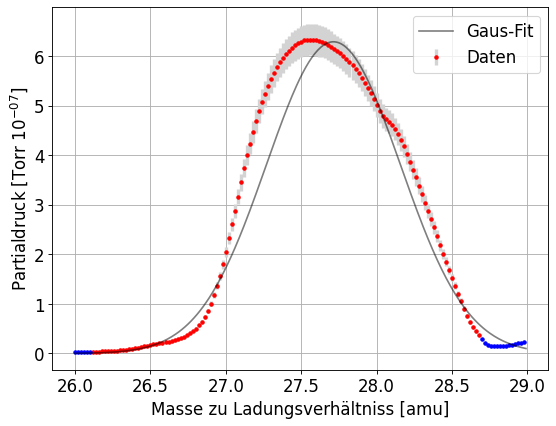

In [17]:
fit_100v2 = gaus1fit(26.12,28.7,'-100%v2',x[0],data[11],err[11],1e7)

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 50
    # variables        = 6
    chi-square         = 39.4498633
    reduced chi-square = 0.89658780
    Akaike info crit   = 0.15037879
    Bayesian info crit = 11.6225168
[[Variables]]
    g1_amplitude:  9.7827e-09 +/- 8.0005e-10 (8.18%) (init = 1e-07)
    g1_center:     28.2547939 +/- 0.00349961 (0.01%) (init = 28.4)
    g1_sigma:      0.11299937 +/- 0.00609207 (5.39%) (init = 0.3)
    g2_amplitude:  1.9371e-08 +/- 1.7130e-09 (8.84%) (init = 3e-08)
    g2_center:     27.9817257 +/- 0.01812697 (0.06%) (init = 27.9)
    g2_sigma:      0.23843774 +/- 0.00809026 (3.39%) (init = 0.3)
    g1_fwhm:       0.26609317 +/- 0.01434572 (5.39%) == '2.3548200*g1_sigma'
    g1_height:     3.4538e-08 +/- 1.2240e-09 (3.54%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.56147797 +/- 0.01905111 (3

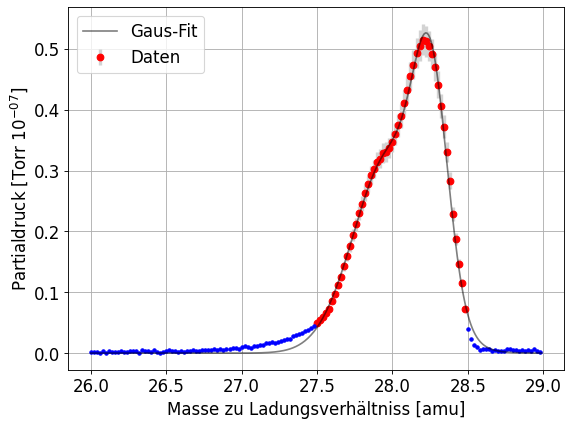

In [18]:
fit10 = gaus2fit(27.5,28.5,'-10%',x[0],data[12],err[12],1e7,override=True,m1=28.4 ,m1min=28.25,m1max=28.5,m2=27.9,m2min=27.6,m2max=28.1,scale1=1e-7,scale2=0.3e-7,s1=0.3,s2=0.3)

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 717
    # data points      = 48
    # variables        = 6
    chi-square         = 99.9002190
    reduced chi-square = 2.37857664
    Akaike info crit   = 47.1826016
    Bayesian info crit = 58.4098077
[[Variables]]
    g1_amplitude:  1.0606e-08 +/- 3.6717e-09 (34.62%) (init = 9.070286e-10)
    g1_center:     28.0605625 +/- 0.08822071 (0.31%) (init = 28.10545)
    g1_sigma:      0.27178853 +/- 0.02913148 (10.72%) (init = 0.45)
    g2_amplitude:  7.3299e-09 +/- 3.0650e-09 (41.81%) (init = 2.721086e-10)
    g2_center:     28.2323012 +/- 0.01169205 (0.04%) (init = 27.10545)
    g2_sigma:      0.13243981 +/- 0.02065954 (15.60%) (init = 0.225)
    g1_fwhm:       0.64001306 +/- 0.06859939 (10.72%) == '2.3548200*g1_sigma'
    g1_height:     1.5567e-08 +/- 3.7757e-09 (24.25%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:    

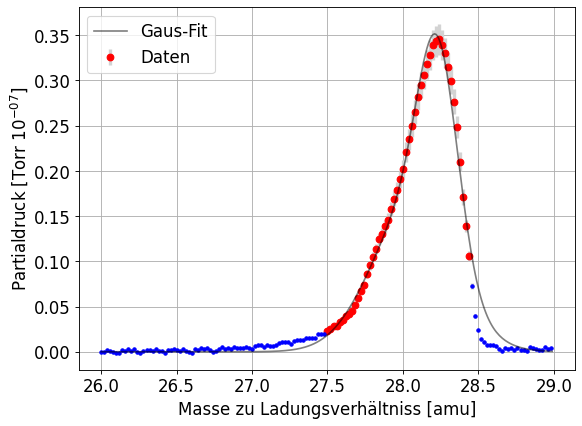

In [19]:
fit20 = gaus2fit(27.5,28.45,'20%',x[0],data[13],err[13],1e7)

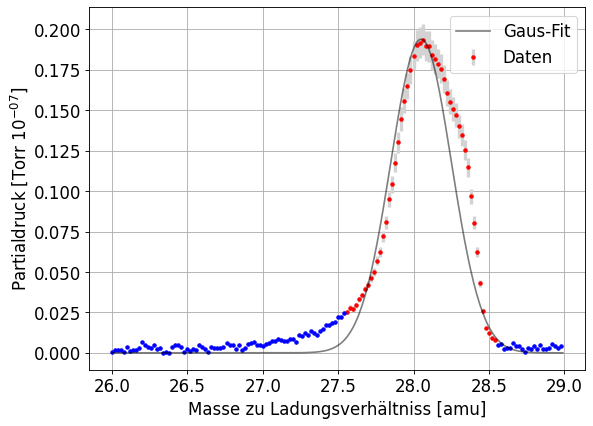

In [20]:
fit30 = gaus1fit(27.55,28.55,'30%',x[0],data[14],err[14],1e7)

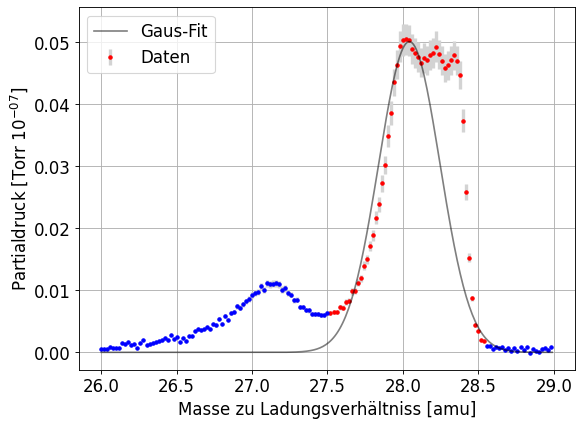

In [21]:
fit40 = gaus1fit(27.52,28.55,'40%',x[0],data[15],err[15],1e7)

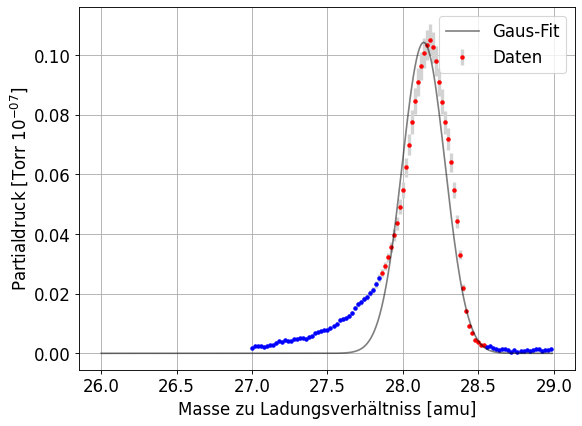

In [22]:
fit50 = gaus1fit(27.852,28.55,'50%',x[1],data[16],err[16],1e7)

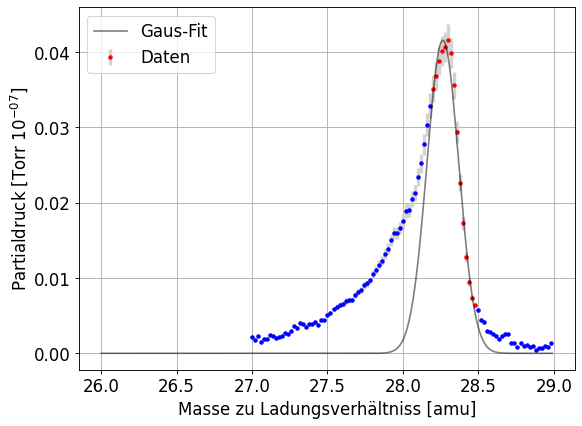

In [23]:
fit60 = gaus1fit(28.2,28.5,'60%',x[1],data[17],err[17],1e7)

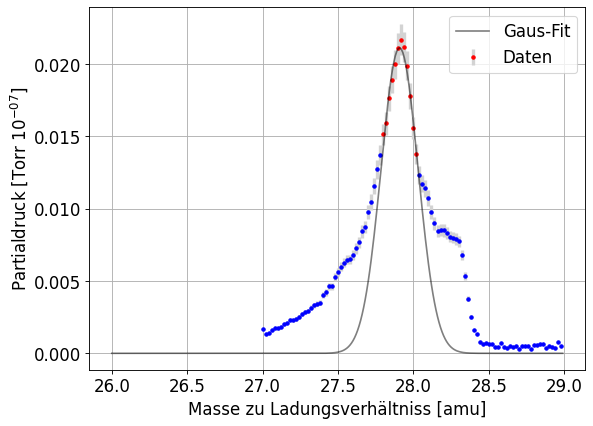

In [24]:
fit70 = gaus1fit(27.79,28.04,'70%',x[1],data[18],err[18],1e7)#override=True,m1=27.9,m1min=27.7,m1max=28,m2=28.25,m2min=27.9,m2max=28.5)

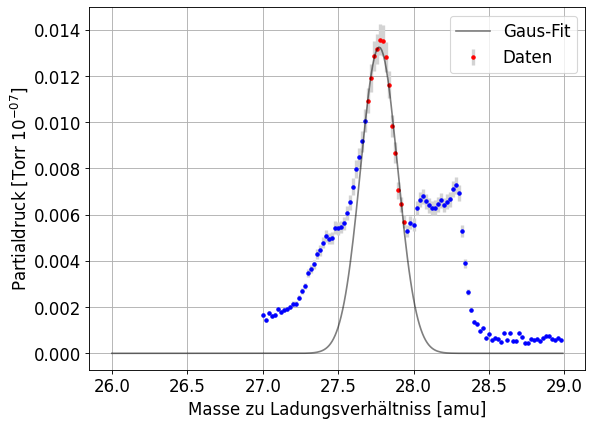

In [25]:
fit80 = gaus1fit(27.69,27.95,'80%',x[1],data[19],err[19],1e7)

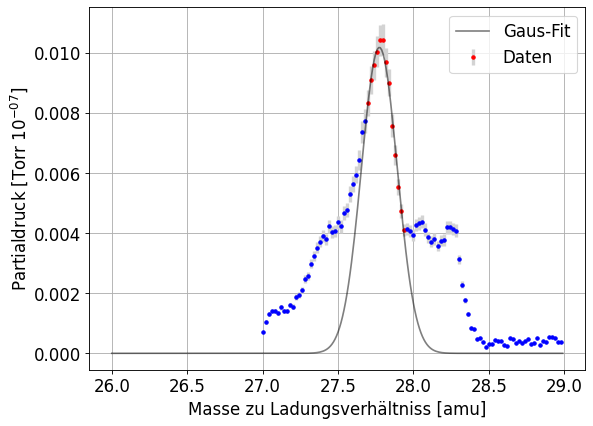

In [26]:
fit90 = gaus1fit(27.69,27.95,'90%',x[1],data[20],err[20],1e7)

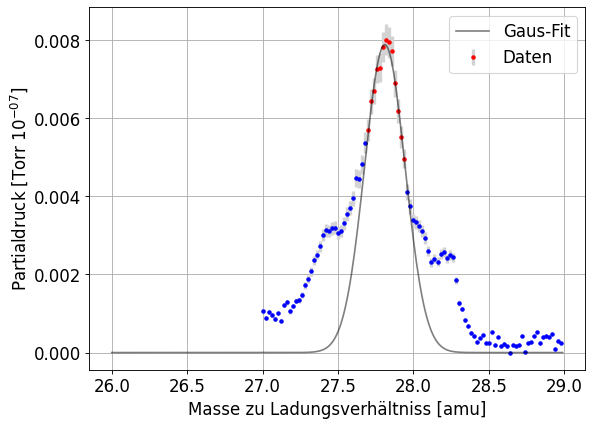

In [27]:
fit100 = gaus1fit(27.69,27.95,'100%',x[1],data[21],err[21],1e7)

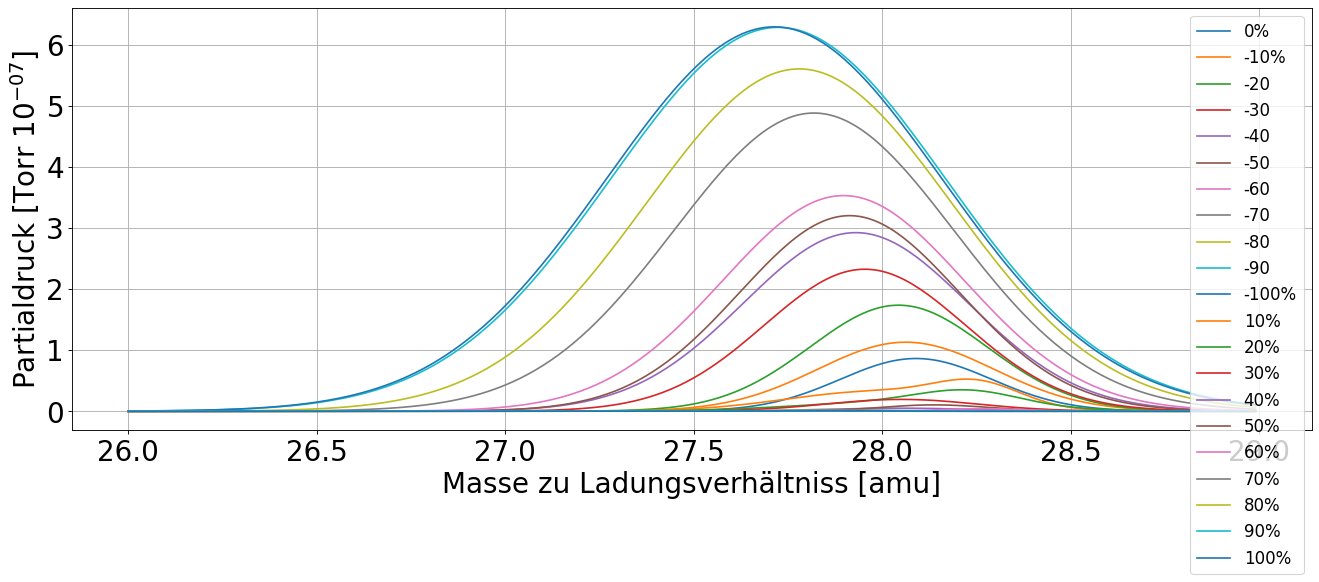

In [28]:
yscale = 1e7
fig = plt.figure(figsize=(20,7),dpi=80,linewidth=50)
plt.rc ('font', size = 25) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 25) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 25) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 25) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 25) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

plt.plot(fit0[0][0],yscale*fit0[0][1],label='0%')
plt.plot(fit_10[0][0],yscale*fit_10[0][1],label='-10%')
plt.plot(fit_20[0][0],yscale*fit_20[0][1],label='-20')
plt.plot(fit_30[0][0],yscale*fit_30[0][1],label='-30')
plt.plot(fit_40[0][0],yscale*fit_40[0][1],label='-40')
plt.plot(fit_50[0][0],yscale*fit_50[0][1],label='-50')
plt.plot(fit_60[0][0],yscale*fit_60[0][1],label='-60')
plt.plot(fit_70[0][0],yscale*fit_70[0][1],label='-70')
plt.plot(fit_80[0][0],yscale*fit_80[0][1],label='-80')
plt.plot(fit_90[0][0],yscale*fit_90[0][1],label='-90')
plt.plot(fit_100v2[0][0],yscale*fit_100v2[0][1],label='-100%')
plt.plot(fit10[0][0],yscale*fit10[0][1],label='10%')
plt.plot(fit20[0][0],yscale*fit20[0][1],label='20%')
plt.plot(fit30[0][0],yscale*fit30[0][1],label='30%')
plt.plot(fit40[0][0],yscale*fit40[0][1],label='40%')
plt.plot(fit50[0][0],yscale*fit50[0][1],label='50%')
plt.plot(fit60[0][0],yscale*fit60[0][1],label='60%')
plt.plot(fit70[0][0],yscale*fit70[0][1],label='70%')
plt.plot(fit80[0][0],yscale*fit80[0][1],label='80%')
plt.plot(fit90[0][0],yscale*fit90[0][1],label='90%')
plt.plot(fit100[0][0],yscale*fit100[0][1],label='100%')


plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()
plt.legend()
plt.savefig('Results/verbreiterung.pdf')

In [29]:
peakheight = [
    fit_100v2[1].params['height'].value,
    fit_90[1].params['height'].value,
    fit_80[1].params['height'].value,
    fit_70[1].params['height'].value,
    fit_60[1].params['height'].value,
    fit_50[1].params['height'].value,
    fit_40[1].params['height'].value,
    fit_30[1].params['height'].value,
    fit_20[1].params['height'].value,
    fit_10[1].params['height'].value,
    fit0[1].params['height'].value,
    fit10[1].params['g1_height'].value,
    fit20[1].params['g1_height'].value,
    fit30[1].params['height'].value,
    fit40[1].params['height'].value,
    fit50[1].params['height'].value,
    fit60[1].params['height'].value,
    fit70[1].params['height'].value,
    fit80[1].params['height'].value,
    fit90[1].params['height'].value,
    fit100[1].params['height'].value
    ]
heighterr = [
    fit_100v2[1].params['height'].stderr,
    fit_90[1].params['height'].stderr,
    fit_80[1].params['height'].stderr,
    fit_70[1].params['height'].stderr,
    fit_60[1].params['height'].stderr,
    fit_50[1].params['height'].stderr,
    fit_40[1].params['height'].stderr,
    fit_30[1].params['height'].stderr,
    fit_20[1].params['height'].stderr,
    fit_10[1].params['height'].stderr,
    fit0[1].params['height'].stderr,
    fit10[1].params['g1_height'].stderr,
    fit20[1].params['g1_height'].stderr,
    fit30[1].params['height'].stderr,
    fit40[1].params['height'].stderr,
    fit50[1].params['height'].stderr,
    fit60[1].params['height'].stderr,
    fit70[1].params['height'].stderr,
    fit80[1].params['height'].stderr,
    fit90[1].params['height'].stderr,
    fit100[1].params['height'].stderr
    ]
deltam = [-100,
    -90,
    -80,
    -70,
    -60,
    -50,
    -40,
    -30,
    -20,
    -10,
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100
    ]

In [30]:
model_lin = lmfit.models.LinearModel()
pars_lin = model_lin.guess(data=peakheight[0:10],x=deltam[0:10])
out_lin =  model_lin.fit(peakheight[0:10],x=deltam[0:10],params=pars_lin,nan_policy='propagate',weights=1/np.array(heighterr[0:10]))


In [31]:
model_exp = lmfit.models.ExponentialModel()
#pars_exp = model_exp.guess(data=peakheight[10:-1],x=deltam[10:-1])
pars_exp = model_exp.make_params()

pars_exp['amplitude'].set(1e-7)
pars_exp['decay'].set(1)

out_exp = model_exp.fit(peakheight[10:-1],x=deltam[10:-1],params=pars_exp,nan_policy='propagate',weights=1/np.array(heighterr[10:-1]))


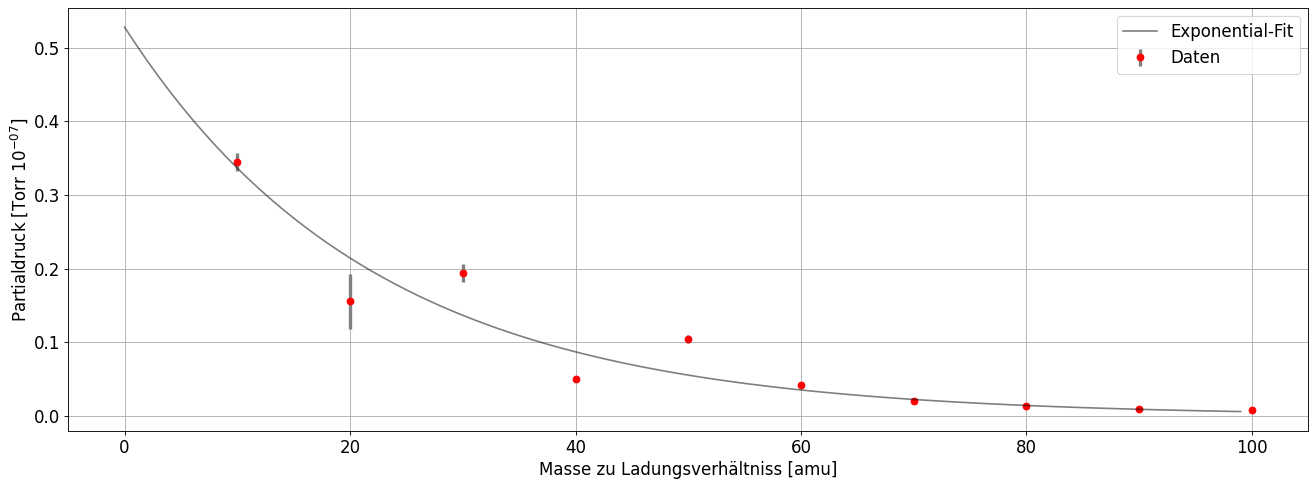

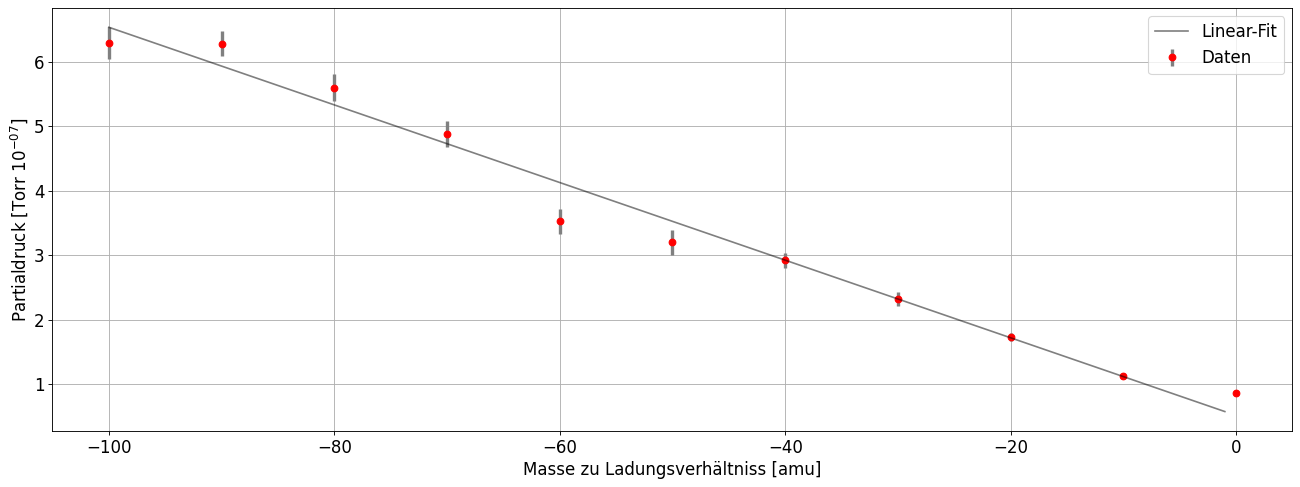

In [40]:
fig = plt.figure(figsize=(20,7),dpi=80,linewidth=50)
yscale = 1e7

plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

plt.errorbar(x=deltam[11:21],y=yscale*np.array(peakheight[11:21]),yerr=yscale*np.array(heighterr[11:21]),fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
plt.plot(np.arange(0,100,1),yscale*out_exp.eval(x=np.arange(0,100,1)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Exponential-Fit")

plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()
plt.legend()
plt.show()



fig = plt.figure(figsize=(20,7),dpi=80,linewidth=50)
yscale = 1e7

plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

plt.errorbar(x=deltam[0:11],y=yscale*np.array(peakheight[0:11]),yerr=yscale*np.array(heighterr[0:11]),fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
plt.plot(np.arange(-100,0,1),yscale*out_lin.eval(x=np.arange(-100,0,1)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Linear-Fit")


plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()
plt.legend()
plt.show()

